## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [12]:
import keras
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau



In [13]:
train, test = keras.datasets.cifar10.load_data()

In [14]:
## 資料前處理
def preproc_x(x, flatten=True):
  x = x / 255.
  if flatten:
      x = x.reshape((len(x), -1))
  return x

def preproc_y(y, num_classes=10):
  if y.shape[-1] == 1:
      y = keras.utils.to_categorical(y, num_classes)
  return y    

In [15]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [16]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
  input_layer = keras.layers.Input(input_shape)
  
  for i, n_units in enumerate(num_neurons):
      if i == 0:
          x = keras.layers.Dense(units=n_units, 
                                  activation="relu", 
                                  name="hidden_layer"+str(i+1))(input_layer)
          x = BatchNormalization()(x)
      else:
          x = keras.layers.Dense(units=n_units, 
                                  activation="relu", 
                                  name="hidden_layer"+str(i+1))(x)
          x = BatchNormalization()(x)
  
  out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
  
  model = keras.models.Model(inputs=[input_layer], outputs=[out])
  return model

## 改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響

In [17]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
RL_PATIENCE = [5, 10, 15]
RL_FACTOR = [0.3, 0.5, 0.7]

In [7]:
results = {}

for i in RL_PATIENCE:
  for j in RL_FACTOR:
    keras.backend.clear_session()
    print(f'EXP: [RL_PATIENCE={i} RL_FACTOR={j}]')
    model = build_mlp(x_train.shape[-1])
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    model.summary()

    reduce_lr = ReduceLROnPlateau(factor=j, 
                          min_lr=1e-12, 
                          monitor='val_loss', 
                          patience=i, 
                          verbose=1)

    model.fit(x_train, y_train, 
            epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(x_test, y_test), 
            shuffle=True,
            callbacks=[reduce_lr]
          )
      
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    name_tag = f'RL_PATIENCE={i} RL_FACTOR={j}'
    results[name_tag] = {
        'train_loss': train_loss,
        'valid_loss': valid_loss,
        'train_acc': train_acc,
        'valid_acc': valid_acc}
    




EXP: [RL_PATIENCE=5 RL_FACTOR=0.3]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Bat

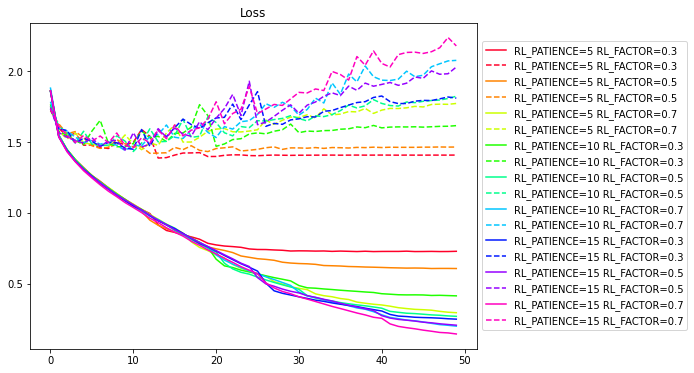

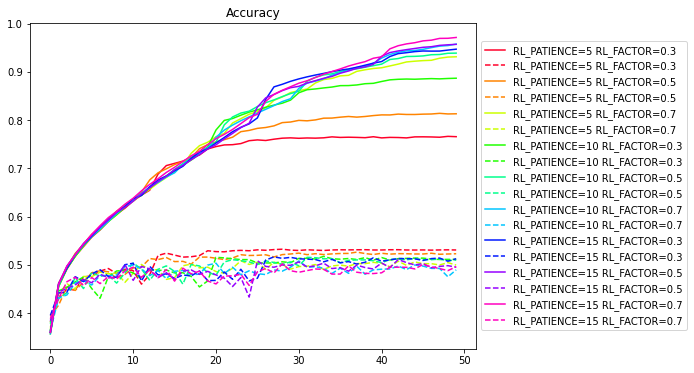

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [9]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
RL_PATIENCE = [5, 10]
RL_FACTOR = [0.3, 0.5]
OPTIMIZER_CHOICES = {
    'SGD':keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM),
    'Adam':keras.optimizers.Adam(lr=LEARNING_RATE),
    'RMSprop':keras.optimizers.RMSprop(lr=LEARNING_RATE)}

In [10]:
results.clear()

for i in RL_PATIENCE:
  for j in RL_FACTOR:
    for k in OPTIMIZER_CHOICES.keys():
      keras.backend.clear_session()
      print(f'EXP: [OPT={k} RL_PATIENCE={i} RL_FACTOR={j}]')
      model = build_mlp(x_train.shape[-1])
      
      model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=OPTIMIZER_CHOICES[k])
      model.summary()

      reduce_lr = ReduceLROnPlateau(factor=j, 
                            min_lr=1e-12, 
                            monitor='val_loss', 
                            patience=i, 
                            verbose=1)

      model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
            )
        
      train_loss = model.history.history["loss"]
      valid_loss = model.history.history["val_loss"]
      train_acc = model.history.history["accuracy"]
      valid_acc = model.history.history["val_accuracy"]

      name_tag = f'OPT={k} RL_PATIENCE={i} RL_FACTOR={j}'
      results[name_tag] = {
          'train_loss': train_loss,
          'valid_loss': valid_loss,
          'train_acc': train_acc,
          'valid_acc': valid_acc}

EXP: [OPT=SGD RL_PATIENCE=5 RL_FACTOR=0.3]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

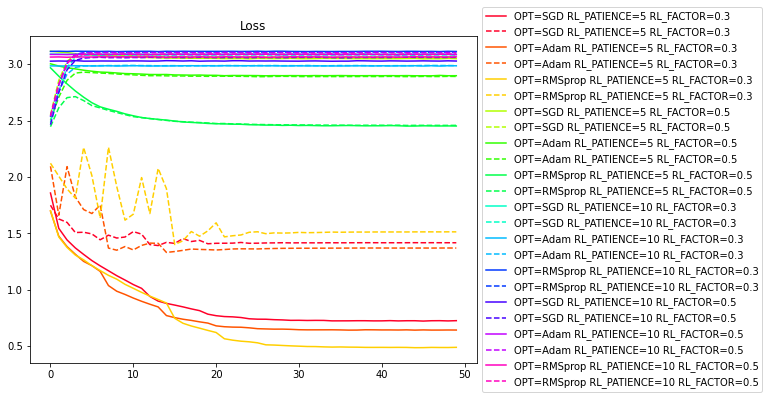

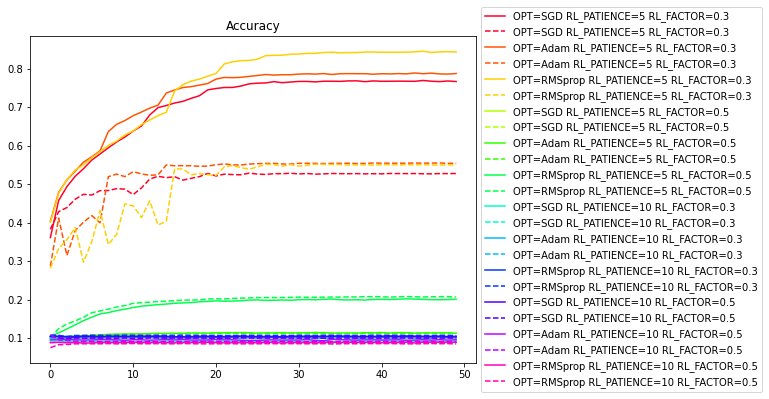

In [11]:
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

